<center><font size="10">Gerar o modelo de predicao</font></center>

Projeto Integrador UNIVESP, 2023, Semestre 1

Autor: Daniel Gaspar Gonçalves

Last Update: 27/04/2023

https://github.com/d-gaspar/univesp-integrador-2023-sem1

# Imports

In [1]:
import os
import pandas as pd
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import pickle # usado para exportar o modelo

In [2]:
output_dir = "./android-app/app/src/main/assets/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Carrega os dados

In [5]:
data_list = []

for filename in os.listdir("data/raw"):
    if filename.endswith(".txt"): # substitua pelo tipo de arquivo que deseja ler
        with open(os.path.join("data/raw", filename)) as file:
            match = re.search('.*-(.*).txt', filename)
            if match:
                weather = match.group(1)
                for line in file:
                    if not re.compile(".*(connect).*", re.IGNORECASE).match(line):
                        line = re.sub('[:HhTPgAa*%mC]', '', line)
                        line = re.sub('\s+', ' ', line)
                        data = line.split()
                        date = data[0]
                        time = data[1]
                        temperature = float(data[2])
                        humidity = float(data[3])/100
                        altitude = float(data[4])
                        pressure = float(data[5])
                        data_list.append([date, time, temperature, humidity, altitude, pressure, weather])
            else:
                print("ERRO (WEATHER): " + filename)
                    
# criar um DataFrame do pandas com a lista de valores
df = pd.DataFrame(data_list, columns=["date", "time", "temperature", "humidity", "altitude", "pressure", "weather"])

print(df)

            date        time  temperature  humidity  altitude  pressure  \
0     2023-04-13  203212.638        25.98    0.6999    874.16    912.57   
1     2023-04-13  203218.768        25.91    0.6942    874.10    912.57   
2     2023-04-13  203221.828        25.88    0.6943    874.13    912.57   
3     2023-04-13  203224.844        25.85    0.6934    874.47    912.53   
4     2023-04-13  203227.927        25.82    0.6932    874.86    912.49   
...          ...         ...          ...       ...       ...       ...   
5783  2023-04-03  110718.278        20.55    0.6527    824.34    918.08   
5784  2023-04-03  110721.357        20.54    0.6527    824.40    918.07   
5785  2023-04-03  110724.545        20.55    0.6526    824.53    918.06   
5786  2023-04-03  110727.524        20.54    0.6524    824.58    918.05   
5787  2023-04-03  110730.573        20.56    0.6520    824.59    918.05   

     weather  
0      night  
1      night  
2      night  
3      night  
4      night  
...      

# Adiciona as colunas ao dataframe

## rainy_timedelta

In [6]:
# Convertendo as colunas "date" e "time" para datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H%M%S.%f')

df = df.sort_values(by='datetime').reset_index(drop=True)

# calcula tempo ate rainy
df['rainy_timedelta'] = 0
for i in range(len(df)):
    if df.loc[i, 'weather'] == 'rainy': # se ja for 'rainy', tempo para o proximo 'rainy' == 0
        df.loc[i, 'rainy_timedelta'] = 0
    else: # se nao, calcula tempo ate o proximo 'rainy'
        rainy_index = (df['datetime'] > df.loc[i, 'datetime']) & (df['weather'] == 'rainy')
        if rainy_index.any():
            first_rainy_index = next((i for i, x in enumerate(rainy_index) if x), None)
            first_rainy_datetime = df.loc[first_rainy_index,'datetime']
            first_rainy_timedelta = int((df.loc[first_rainy_index,'datetime'] - df.loc[i,'datetime']).total_seconds() / 3600)
            df.loc[i, 'rainy_timedelta'] = first_rainy_timedelta
        else: # nao houve chuva apos estas leituras
            df.loc[i, 'rainy_timedelta'] = -1

# remove todas as linhas onde rainy_timedata = -1
df = df.loc[~df['rainy_timedelta'].isin([-1])].reset_index(drop=True)

df

,date,time,temperature,humidity,altitude,pressure,weather,datetime,rainy_timedelta
0,2023-03-29,093526.903,24.43,0.6767,827.66,917.71,sunny,2023-03-29 09:35:26.903,10
1,2023-03-29,093529.995,24.43,0.6759,827.87,917.69,sunny,2023-03-29 09:35:29.995,10
2,2023-03-29,093533.044,24.42,0.6754,827.80,917.69,sunny,2023-03-29 09:35:33.044,10
3,2023-03-29,093536.202,24.42,0.6766,827.57,917.72,sunny,2023-03-29 09:35:36.202,10
4,2023-03-29,093539.150,24.42,0.6768,827.68,917.71,sunny,2023-03-29 09:35:39.150,10
...,...,...,...,...,...,...,...,...,...
5523,2023-04-12,170203.427,23.45,0.7328,865.51,913.52,rainy,2023-04-12 17:02:03.427,0
5524,2023-04-12,170206.453,23.46,0.7329,865.25,913.54,rainy,2023-04-12 17:02:06.453,0
5525,2023-04-12,170209.541,23.45,0.7338,865.56,913.52,rainy,2023-04-12 17:02:09.541,0
5526,2023-04-12,170212.593,23.45,0.7341,865.29,913.55,rainy,2023-04-12 17:02:12.593,0


## rainy_6h, rainy_12h, rainy_24h

In [7]:
df['rainy_6h'] = (df['rainy_timedelta'] <= 6).astype(str)
df['rainy_12h'] = (df['rainy_timedelta'] <= 12).astype(str)

# df['rainy_24h'] = (df['rainy_timedelta'] <= 24).astype(int)
df['rainy_24h'] = (df['rainy_timedelta'] <= 24).astype(str)

df

,date,time,temperature,humidity,altitude,pressure,weather,datetime,rainy_timedelta,rainy_6h,rainy_12h,rainy_24h
0,2023-03-29,093526.903,24.43,0.6767,827.66,917.71,sunny,2023-03-29 09:35:26.903,10,False,True,True
1,2023-03-29,093529.995,24.43,0.6759,827.87,917.69,sunny,2023-03-29 09:35:29.995,10,False,True,True
2,2023-03-29,093533.044,24.42,0.6754,827.80,917.69,sunny,2023-03-29 09:35:33.044,10,False,True,True
3,2023-03-29,093536.202,24.42,0.6766,827.57,917.72,sunny,2023-03-29 09:35:36.202,10,False,True,True
4,2023-03-29,093539.150,24.42,0.6768,827.68,917.71,sunny,2023-03-29 09:35:39.150,10,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5523,2023-04-12,170203.427,23.45,0.7328,865.51,913.52,rainy,2023-04-12 17:02:03.427,0,True,True,True
5524,2023-04-12,170206.453,23.46,0.7329,865.25,913.54,rainy,2023-04-12 17:02:06.453,0,True,True,True
5525,2023-04-12,170209.541,23.45,0.7338,865.56,913.52,rainy,2023-04-12 17:02:09.541,0,True,True,True
5526,2023-04-12,170212.593,23.45,0.7341,865.29,913.55,rainy,2023-04-12 17:02:12.593,0,True,True,True


# predicao para 6h

In [8]:
# Separa as variaveis independentes da variavel dependente
X = df[["temperature", "humidity", "pressure"]]
y = df["rainy_6h"]

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## arvore de decisao

Accuracy: 0.95


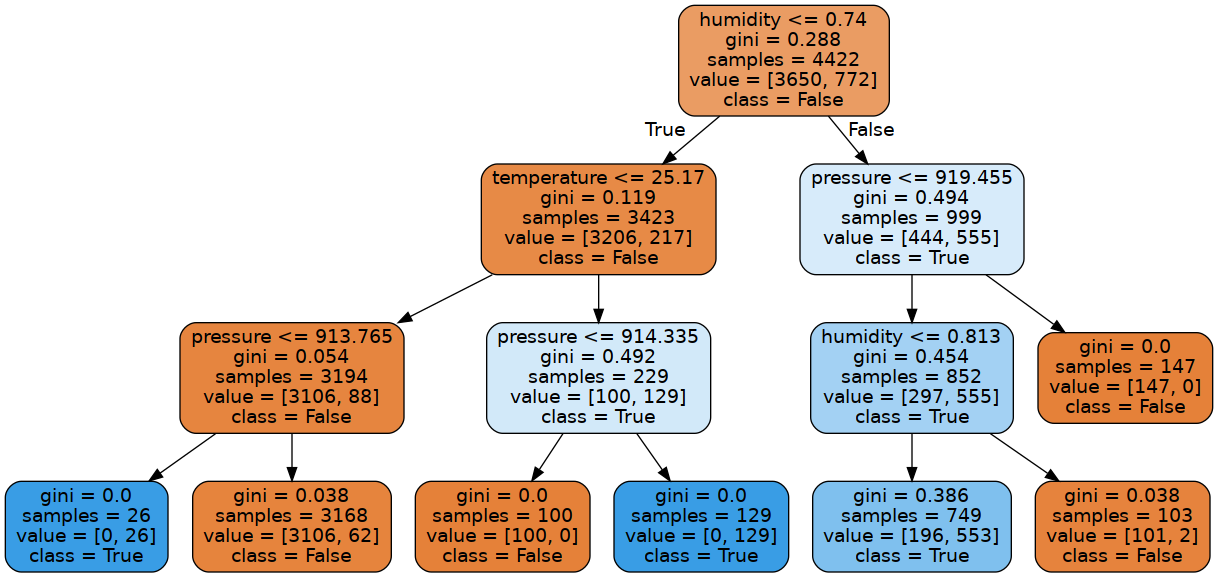

In [9]:
model_dt = DecisionTreeClassifier(max_depth=3)
model_dt.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = model_dt.predict(X_test)

# Avaliando o desempenho do modelo com a métrica de acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

dot_data = export_graphviz(
        model_dt,
        out_file=None,
        feature_names=X.columns,#["temperature", "humidity", "pressure"],
        class_names=y.unique(),
        rounded=True,
        filled=True
    )

graph = graphviz.Source(dot_data)
Image(graph.pipe(format='png'))

## regressao logistica

In [10]:
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)

# faz previsões nos dados de teste
y_pred = model_lr.predict(X_test)

# avalia o desempenho do modelo com a métrica de acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

Accuracy: 0.85


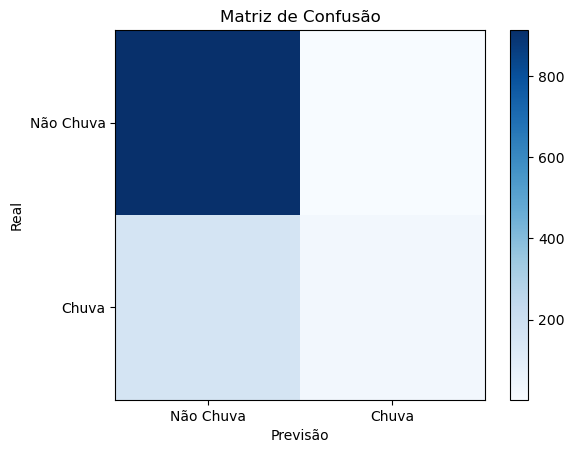

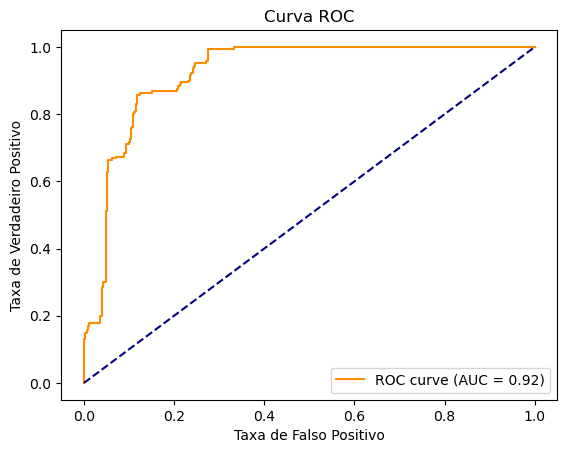

In [11]:
# cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# plotagem da matriz de confusão
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Não Chuva', 'Chuva'])
plt.yticks([0, 1], ['Não Chuva', 'Chuva'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# cálculo da curva ROC
y_prob = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label="True")

# cálculo da área sob a curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_prob)

# plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [12]:
with open(output_dir + 'model_logisticReg_6h.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

# predicao para 12h

In [13]:
# Separa as variaveis independentes da variavel dependente
X = df[["temperature", "humidity", "pressure"]]
y = df["rainy_12h"]

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## arvore de decisao

Accuracy: 0.90


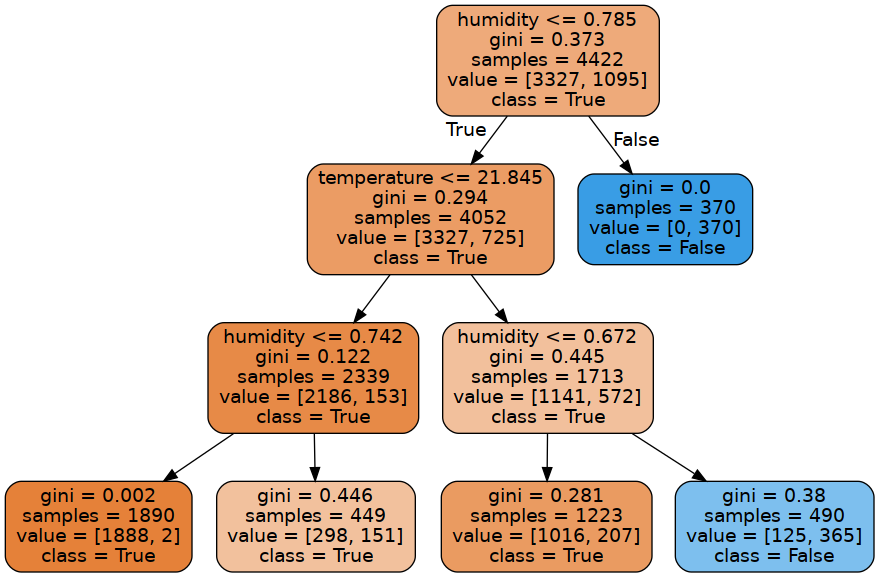

In [14]:
model_dt = DecisionTreeClassifier(max_depth=3)
model_dt.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = model_dt.predict(X_test)

# Avaliando o desempenho do modelo com a métrica de acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

dot_data = export_graphviz(
        model_dt,
        out_file=None,
        feature_names=X.columns,#["temperature", "humidity", "pressure"],
        class_names=y.unique(),
        rounded=True,
        filled=True
    )

graph = graphviz.Source(dot_data)
Image(graph.pipe(format='png'))

## regressao logistica

In [15]:
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)

# faz previsões nos dados de teste
y_pred = model_lr.predict(X_test)

# avalia o desempenho do modelo com a métrica de acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

Accuracy: 0.83


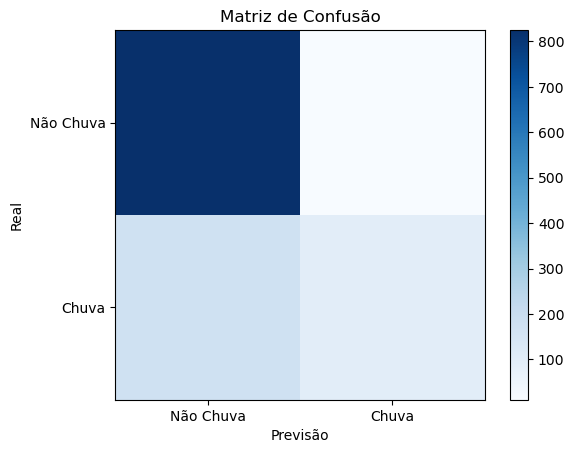

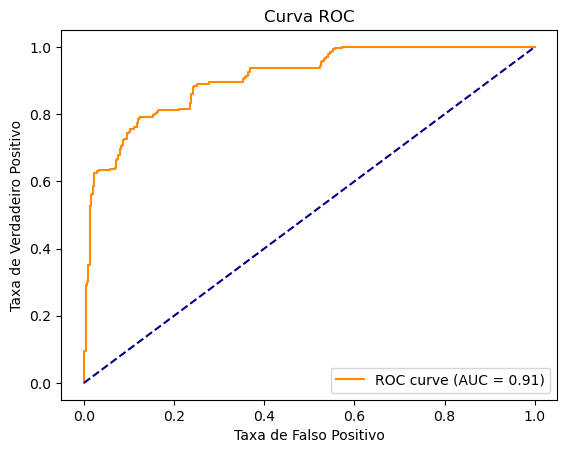

In [16]:
# cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# plotagem da matriz de confusão
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Não Chuva', 'Chuva'])
plt.yticks([0, 1], ['Não Chuva', 'Chuva'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# cálculo da curva ROC
y_prob = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label="True")

# cálculo da área sob a curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_prob)

# plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [17]:
with open(output_dir + 'model_logisticReg_12h.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

# predicao para 24h

In [18]:
# Separa as variaveis independentes da variavel dependente
X = df[["temperature", "humidity", "pressure"]]
y = df["rainy_24h"]

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## arvore de decisao

Accuracy: 0.84


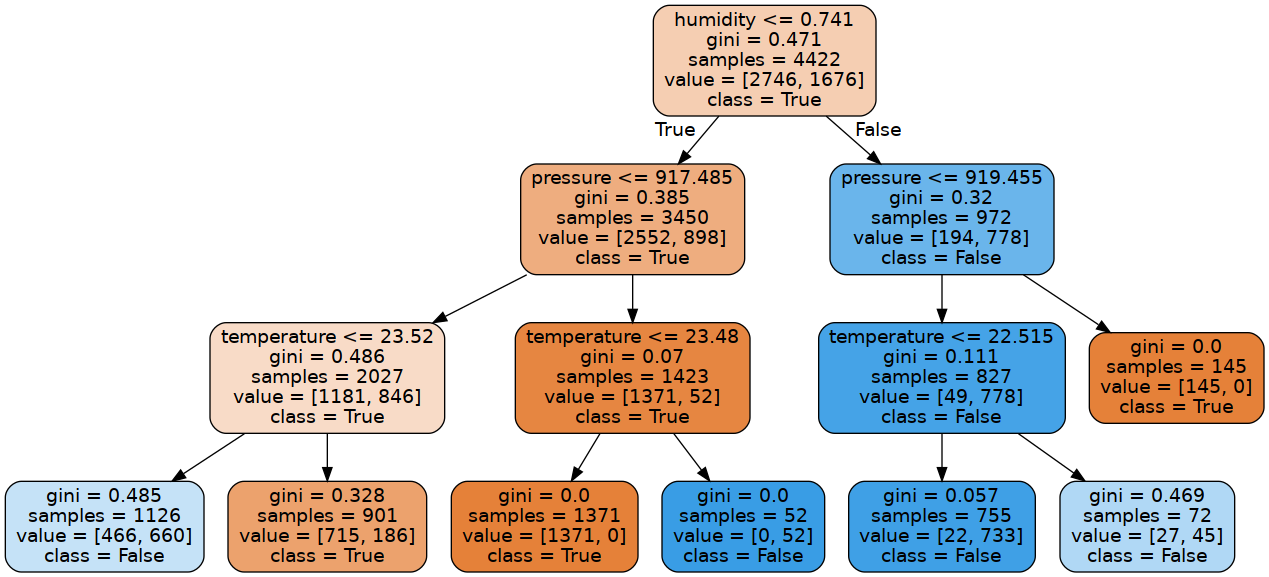

In [19]:
model_dt = DecisionTreeClassifier(max_depth=3)
model_dt.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = model_dt.predict(X_test)

# Avaliando o desempenho do modelo com a métrica de acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

dot_data = export_graphviz(
        model_dt,
        out_file=None,
        feature_names=X.columns,#["temperature", "humidity", "pressure"],
        class_names=y.unique(),
        rounded=True,
        filled=True
    )

graph = graphviz.Source(dot_data)
Image(graph.pipe(format='png'))

## regressao logistica

In [20]:
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)

# faz previsões nos dados de teste
y_pred = model_lr.predict(X_test)

# avalia o desempenho do modelo com a métrica de acurácia
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

Accuracy: 0.81


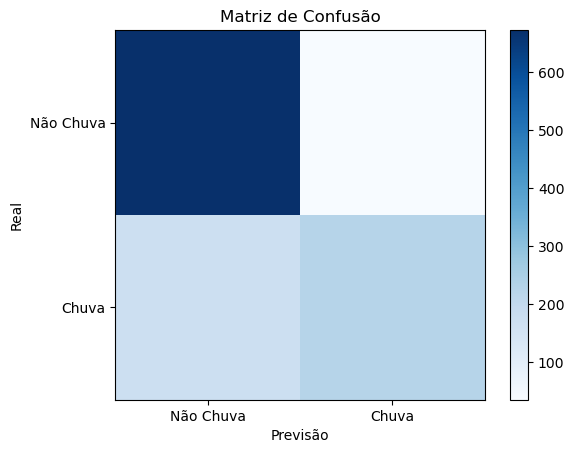

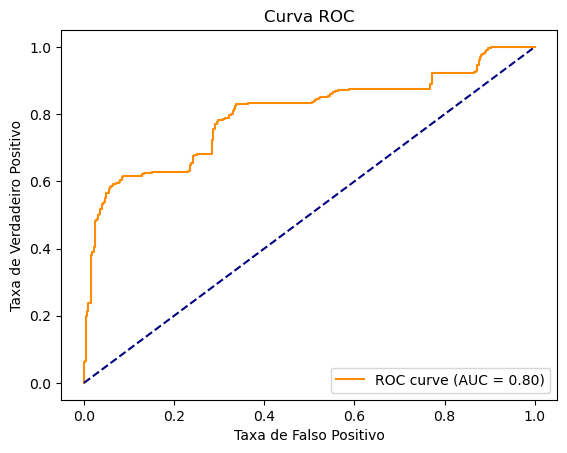

In [21]:
# cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# plotagem da matriz de confusão
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Não Chuva', 'Chuva'])
plt.yticks([0, 1], ['Não Chuva', 'Chuva'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# cálculo da curva ROC
y_prob = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label="True")

# cálculo da área sob a curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_prob)

# plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [22]:
with open(output_dir + 'model_logisticReg_24h.pkl', 'wb') as f:
    pickle.dump(model_lr, f)